In [1]:
import os
import random
import math
import kornia
from math import acos
from math import sqrt
from math import pi
import numpy as np
import pandas as pd
from shapely.geometry import Polygon
import pdb
from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
matplotlib.rcParams['figure.figsize'] = [6, 6]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

from data_helper import UnlabeledDataset, LabeledDataset
from helper import draw_box

# random.seed(0)
# np.random.seed(0)
# torch.manual_seed(0);

# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = '/scratch/brs426/data'
annotation_csv = '/scratch/brs426/data/annotation.csv'

# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
train_labeled_scene_index = np.arange(106, 132)
val_labeled_scene_index = np.arange(132, 134)
test_labeled_scene_index = np.arange(132, 134)

from helper import compute_ats_bounding_boxes, compute_ts_road_map

In [2]:
def length(v):
    return sqrt(v[0]**2+v[1]**2)

def dot_product(v,w):
    return v[0]*w[0]+v[1]*w[1]

def determinant(v,w):
    return v[0]*w[1]-v[1]*w[0]

def inner_angle(v,w):
    cosx=dot_product(v,w)/(length(v)*length(w))
    rad=acos(cosx) # in radians
    return rad*180/pi # returns degrees

def angle_clockwise(A, B):
    inner=inner_angle(A,B)
    det = determinant(A,B)
    if det<0: #this is a property of the det. If the det < 0 then B is clockwise of A
        return inner
    else: # if the det > 0 then A is immediately clockwise of B
        return 360-inner

In [3]:
def within_angles(xs, ys, angle1 = 270, angle2 = 330):
    '''
    xs and ys must be corresponding coordinates in matplotlib-space (y-axis 0 starts from the top).
    '''
    
    # Matplotlib y-axis -- 0 starts from the top, so we need to adjust. 
    v0 = np.array([xs[0] - 400, 800 - ys[0] - 400])
    v1 = np.array([xs[1] - 400, 800 - ys[1] - 400])
    v2 = np.array([xs[2] - 400, 800 - ys[2] - 400])
    v3 = np.array([xs[3] - 400, 800 - ys[3] - 400])
    v_ref = np.array([2, 0])
    
    condition = (angle_clockwise(v_ref, v0) >= angle1 and angle_clockwise(v_ref, v0) <= angle2) or \
                (angle_clockwise(v_ref, v1) >= angle1 and angle_clockwise(v_ref, v1) <= angle2) or \
                (angle_clockwise(v_ref, v2) >= angle1 and angle_clockwise(v_ref, v2) <= angle2) or \
                (angle_clockwise(v_ref, v3) >= angle1 and angle_clockwise(v_ref, v3) <= angle2)
    return condition

In [4]:
BLOCK_SIZE = 5

In [5]:
def collate_fn(batch):
    BLOCK_SIZE = 5
    left_images = []
    target = []
    road_maps = []
    bbox_maps = []
    bbox_bins = []
    bbs = []
    target_counts = []
    for x in batch:
        
        # Get road_image and cast it to float
        road_image = torch.as_tensor(x[2]).float()
        road_maps.append(road_image)
        
        # Collect six images for this sample. 
        # TODO: Try cutting off the top 100 pixels (that can lead to overfitting)
        image = torch.Tensor(x[0][0])
        left_images.append(image)
        
        # target
        bb_tens = x[1]['bounding_box']
        current_bbs = []
        bbox_map = torch.zeros((800, 800))
        counts = np.zeros(8)
        count = 0
        
        # Create the bounding box map. 
        for i, corners in enumerate(bb_tens):
            
            # Grab the current bounding box. 
            current_bbs.append(corners)
            
            # Get its four bird's-eye view coordinates. 
            point_squence = torch.stack([corners[:, 0], corners[:, 1], corners[:, 3], corners[:, 2]])
            xs = point_squence.T[0] * 10 + 400
            ys = -point_squence.T[1] * 10 + 400
            
            # xs is horizontal, ys is vertical through. 
            # But we're doing things row, column way. 
            
            # Only get the bounding boxes that are close-by. On the same road. 
            # We want to see if the model can fucking predict cars that are close by. 
            
            center_x, center_y = torch.mean(xs).item(), torch.mean(ys).item()
            if within_angles(xs, ys) and center_y > 300 and center_y < 525:
            
                # Grab the top-left coordinates. 
                r, c = int(torch.min(ys).item()), int(torch.min(xs).item())
                r_len, c_len = int(torch.max(ys).item()) - r, int(torch.max(xs).item()) - c

                # Fill in the bbox. 
                bbox_map[r:r+r_len, c:c+c_len] = 1.0

                count += 1
            
        # Convert the bounding box map into classes (5px by 5px bins)
        bbox_grid = []
        for x_ in range(0, 800, BLOCK_SIZE):
            for y in range(0, 800, BLOCK_SIZE):
                block = bbox_map[x_:x_+BLOCK_SIZE, y:y+BLOCK_SIZE]
                score = torch.sum(block).item()
                # If more than have the pixels are 1, classify as bbox car
                if score > 0.5 * (BLOCK_SIZE**2):
                    bbox_grid.append(1.0)
                else:
                    bbox_grid.append(0.0)
                    
        bbox_bins.append(torch.Tensor(bbox_grid))
              
        counts[count] = 1

        # Label Smoothing #
#         if count > 15 and count < 88:
#             counts[count+1] = 0.2
#             counts[count-1] = 0.2
            
        target_counts.append(torch.Tensor(counts))
        
        bbox_maps.append(bbox_map)

        bbs.append(current_bbs)
                
    boom = torch.stack(left_images), torch.stack(bbox_bins), torch.stack(road_maps), bbs, torch.stack(target_counts), torch.stack(bbox_maps) 
    return boom

In [6]:
val_transform = transforms.ToTensor()

labeled_valset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=val_labeled_scene_index,
                                  transform=val_transform,
                                  extra_info=True
                                 )

In [7]:
# Compute threat scores
def reconstruct_from_bins(bins, block_size, threshold):
    road_map = torch.zeros((800, 800))
    idx = 0
    for x in range(0, 800, block_size):
        for y in range(0, 800, block_size):
            road_map[x:x+block_size, y:y+block_size] = bins[idx]
            idx += 1
    return road_map > threshold

In [8]:
def draw_vish_box(ax, class_box, width, height, color):
    box_xs = [class_box[1], class_box[1], class_box[1]+width, class_box[1]+width, class_box[1]]
    box_ys = [class_box[0], class_box[0]+height, class_box[0]+height, class_box[0], class_box[0]]
    ax.plot(box_xs, box_ys, color=color)

In [9]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        
        self.encoder = torchvision.models.resnet18()
        self.encoder.fc = nn.Identity()
        self.concat_dim = 100
        self.dropout = nn.Dropout(p = 0.2)
        self.bn = nn.BatchNorm1d(self.concat_dim)
        
        self.compress = nn.Sequential(OrderedDict([
            ('linear0', nn.Linear(512, 100)),
            ('relu', nn.ReLU()),
        ]))
        
        self.vehicle_map = nn.Sequential(OrderedDict([
            ('linear1_vehicle', nn.Linear(self.concat_dim, 25600)),
        ]))
        
        self.counts = nn.Sequential(OrderedDict([
            ('count1', nn.Linear(self.concat_dim, 8))
        ]))
        
    def forward(self, x):
        
        batch_size = x.shape[0]
        channels = x.shape[1]
        height = x.shape[2]
        width = x.shape[3]
        # Reshape here
        x = x.view(-1, channels, height, width)
        x = self.encoder(x)
        x = self.compress(x)
        x = x.view(-1, self.concat_dim)
        x = self.bn(x)
        x = self.dropout(x)
    
        return self.vehicle_map(x), self.counts(x)

In [83]:
device = torch.device("cpu")
model = SimpleModel().to(device)
model.load_state_dict(torch.load('/scratch/vr1059/left_image.pt', map_location=device))

<All keys matched successfully>

In [84]:
model.eval()
print('done.')

done.


In [85]:
val_loader = torch.utils.data.DataLoader(labeled_valset, batch_size=15, shuffle=True, collate_fn=collate_fn)

In [142]:
sample, bbox_bins, road_maps, bbs, counts, bbox_maps = iter(val_loader).next()

In [143]:
y_vehicle, y_count = model(sample)

In [144]:
idx = -1

In [167]:
idx += 1

tensor(1)


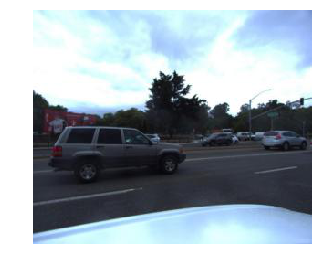

In [168]:
print(torch.argmax(counts[idx]))
matplotlib.rcParams['figure.figsize'] = [5,5]
plt.imshow(sample[idx].numpy().transpose(1, 2, 0))
plt.axis('off');

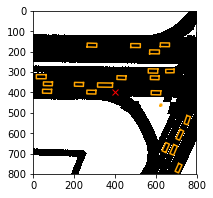

In [169]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [3,3]

fig, ax = plt.subplots()
ax.imshow(road_maps[idx], cmap ='binary');
ax.plot(400, 400, 'x', color="red")
for bb in bbs[idx]:
    draw_box(ax, bb, 'orange')

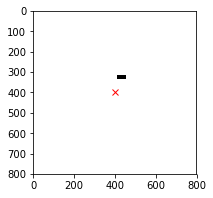

In [170]:
fig, ax = plt.subplots()
ax.imshow(bbox_maps[idx], cmap ='binary');
ax.plot(400, 400, 'x', color="red")

In [171]:
pred_bb_map = torch.sigmoid(y_vehicle[idx])

In [172]:
print(torch.max(pred_bb_map))

tensor(0.4756, grad_fn=<MaxBackward1>)


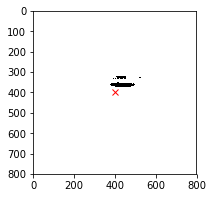

In [173]:
threshold = 0.15
reconstructed_bb_map = reconstruct_from_bins(pred_bb_map, BLOCK_SIZE, threshold).cpu()

fig, ax = plt.subplots()
ax.imshow(reconstructed_bb_map, cmap ='binary');
ax.plot(400, 400, 'x', color="red")

In [174]:
# TODO: Change this to not transpose in the collate_fn and stuff. With the newest model. 
bb_map = reconstructed_bb_map.clone()

def go(direction, top_left, width, height):
    threshold = 0.0
    r, c = top_left
    delta = 5
    if direction == 'right':
        c = c + width 
        # now we're at the top-right coordinate. 
        while c + delta < 800:
            block = bb_map[r:r+height, c:c+delta]
            score = torch.sum(block).item()
            if score > threshold * height * delta:
                c = c + delta
                width = width + delta
            else:
                break
                
        return top_left, width, height
                
    elif direction == 'left':
        # At top-left coordinate. 
        while c - delta > 0:
            block = bb_map[r:r+height, c-delta:c]
            score = torch.sum(block).item()
            if score > threshold * height * delta:
                c = c - delta
                width = width + delta
            else:
                break
        
        return (r, c), width, height
    
    elif direction == 'up':
        # At top_left coordinate. 
        while r - delta > 0:
            block = bb_map[r-delta:r, c:c+width]
            score = torch.sum(block).item()
            if score > threshold * width * delta:
                r = r - delta
                height = height + delta
            else:
                break
        
        return (r, c), width, height
    
    elif direction == 'down':
        r = r + delta
        # At bottom_left coordinate. 
        while r + delta < 800:
            block = bb_map[r:r+delta, c:c+width]
            score = torch.sum(block).item()
            if score > threshold * width * delta:
                r = r + delta
                height = height + delta
            else:
                break
        
        return top_left, width, height
        
        
bboxes = []
for r in range(0, 800, 10):
    for c in range(0, 800, 10):
        
        top_left = (r, c)
        width = BLOCK_SIZE
        height = BLOCK_SIZE
        
        block = bb_map[r:r+BLOCK_SIZE, c:c+BLOCK_SIZE]
        score = torch.sum(block).item()
        # If more than have the pixels are 1, classify as bbox car
        if score > (BLOCK_SIZE**2) / 2:
            top_left, width, height = go('right', top_left, width, height)
            top_left, width, height = go('left', top_left, width, height)
            top_left, width, height = go('up', top_left, width, height)
            top_left, width, height = go('down', top_left, width, height)
            
            bboxes.append((top_left, width, height))
            bb_map[top_left[0]:top_left[0] + height, top_left[1]:top_left[1] + width] = 0     

In [175]:
print(len(bboxes))
new_bboxes = []
for x in bboxes:
    _, width, height = x
    if width * height > 300:
        new_bboxes.append(x)
        
bboxes = new_bboxes
print(len(bboxes))

6
3


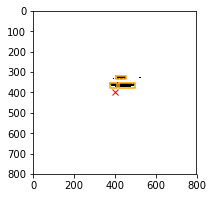

In [176]:
threshold = 0.15
reconstructed_bb_map = reconstruct_from_bins(pred_bb_map, BLOCK_SIZE, threshold).cpu()

fig, ax = plt.subplots()
ax.imshow(reconstructed_bb_map, cmap ='binary');
ax.plot(400, 400, 'x', color="red")
for bb in bboxes:
    draw_vish_box(ax, bb[0], bb[1], bb[2], 'orange')

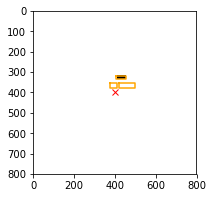

In [177]:
fig, ax = plt.subplots()
ax.imshow(bbox_maps[idx], cmap ='binary');
ax.plot(400, 400, 'x', color="red")
for bb in bboxes:
    draw_vish_box(ax, bb[0], bb[1], bb[2], 'orange')

In [178]:
compute_bbox_score(bboxes, bbs, idx, log=True)

tensor([0.0000, 0.0000, 0.0000, 0.1219, 0.0000, 0.7330, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000])


tensor(0.0297)

In [33]:
def compute_ats_bounding_boxes(boxes1, boxes2, log=False):
    num_boxes1 = boxes1.size(0)
    num_boxes2 = boxes2.size(0)

    boxes1_max_x = boxes1[:, 0].max(dim=1)[0]
    boxes1_min_x = boxes1[:, 0].min(dim=1)[0]
    boxes1_max_y = boxes1[:, 1].max(dim=1)[0]
    boxes1_min_y = boxes1[:, 1].min(dim=1)[0]

    boxes2_max_x = boxes2[:, 0].max(dim=1)[0]
    boxes2_min_x = boxes2[:, 0].min(dim=1)[0]
    boxes2_max_y = boxes2[:, 1].max(dim=1)[0]
    boxes2_min_y = boxes2[:, 1].min(dim=1)[0]

    condition1_matrix = (boxes1_max_x.unsqueeze(1) > boxes2_min_x.unsqueeze(0))
    condition2_matrix = (boxes1_min_x.unsqueeze(1) < boxes2_max_x.unsqueeze(0))
    condition3_matrix = (boxes1_max_y.unsqueeze(1) > boxes2_min_y.unsqueeze(0))
    condition4_matrix = (boxes1_min_y.unsqueeze(1) < boxes2_max_y.unsqueeze(0))
    condition_matrix = condition1_matrix * condition2_matrix * condition3_matrix * condition4_matrix

    iou_matrix = torch.zeros(num_boxes1, num_boxes2)
    for i in range(num_boxes1):
        for j in range(num_boxes2):
            if condition_matrix[i][j]:
                iou_matrix[i][j] = compute_iou(boxes1[i], boxes2[j])

    iou_max = iou_matrix.max(dim=0)[0]
    if log:
        print(iou_max)
    

    iou_thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
    total_threat_score = 0
    total_weight = 0
    for threshold in iou_thresholds:
        tp = (iou_max > threshold).sum()
        threat_score = tp * 1.0 / (num_boxes1 + num_boxes2 - tp)
        total_threat_score += 1.0 / threshold * threat_score
        total_weight += 1.0 / threshold

    average_threat_score = total_threat_score / total_weight

    return average_threat_score




def compute_ts_road_map(road_map1, road_map2):
    tp = (road_map1 * road_map2).sum()

    return tp * 1.0 / (road_map1.sum() + road_map2.sum() - tp)

def compute_iou(box1, box2):
    a = Polygon(torch.t(box1)).convex_hull
    b = Polygon(torch.t(box2)).convex_hull

    return a.intersection(b).area / a.union(b).area

In [34]:
def compute_bbox_score(bboxes, bbs, idx, log=False):
    bb_samples = []

    bounding_boxes = []
    for bb in bboxes:
        top_left, width, height = bb
        r, c = top_left
        xs = torch.Tensor([c, c+width, c+width, c])
        ys = torch.Tensor([r, r, r+height, r+height])

        xs = xs - 400
        ys = 800 - ys # right-side up
        ys = ys - 400

        xs /= 10.
        ys /= 10.

        coords = torch.stack((xs, ys))
        bounding_boxes.append(coords)

    bounding_boxes = torch.stack(bounding_boxes).double()
    bb_samples.append(bounding_boxes)
    bb_samples = tuple(bb_samples)
    
    return compute_ats_bounding_boxes(bb_samples[0].cpu(), torch.stack(bbs[idx]).cpu(), log)